In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
from scipy.stats import mannwhitneyu
import datetime
import json
import pickle
from tqdm import tqdm
import warnings
import lightgbm as lgb
import math
import random
import pdb
import re
from collections import defaultdict
warnings.filterwarnings(action='ignore')

from sklearn.metrics import *
from sklearn.model_selection import KFold

def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

def split_time(x):
    x = str(x)
    year = x[:4]
    month = x[4:6]
    day = x[6:8]
    hour = x[8:10]
    minute = x[10:12]
    second = x[12:14]
    return year, month, day, hour, minute, second

def make_time_cols(df_):
    years, months, days, hours, minutes, seconds, dates = [], [], [], [], [], [], []

    for i in range(len(df_)):
        x = df_.loc[i,'time']
        year, month, day, hour, minute, second = split_time(x)
        years.append(int(year))
        months.append(int(month))
        days.append(int(day))
        hours.append(int(hour))
        minutes.append(int(minute))
        seconds.append(int(second))
        dates.append(datetime.datetime.strptime(str(x), "%Y%m%d%H%M%S"))

    df_['year'] = years
    df_['month'] = months
    df_['day'] = days
    df_['hour']=hours
    df_['minute'] = minutes
    df_['second']= seconds
    df_['date'] = dates
    return df_


def add_time_cols(df_):
    df_ = make_time_cols(df_)
    df_['weeknum'] = df_['date'].apply(lambda x: x.weekday())
    df_['weekend'] = df_['weeknum'].apply(lambda x: 1 if x >=5 else 0)
    df_['md'] = df_['month'].apply(lambda x: str(x).zfill(2)) + df_['day'].apply(lambda x: str(x).zfill(2))
    return df_

In [2]:
default_path = os.getcwd()
data_path = os.path.join(default_path,'data')

In [3]:
def processing_train_test(data_path, option='train'):
    if option == 'train':
        err_name = 'train_err_data'
        qua_name = 'train_quality_data'
        prob_name = 'train_problem_data'
    elif option == 'test':
        err_name = 'test_err_data'
        qua_name = 'test_quality_data'
    
    df_err = pd.read_csv(data_path+f'/{err_name}.csv')
    df_err['errcode'] = df_err['errcode'].astype('str')
    df_qua = pd.read_csv(data_path+f'/{qua_name}.csv')
    
    for i in range(13):
        df_qua[f'quality_{i}'] = df_qua[f'quality_{i}'].apply(lambda x: re.sub(r"[^-0-9]+", '', str(x)) if type(x) == str else x)
        df_qua[f'quality_{i}'] = df_qua[f'quality_{i}'].astype(float)
    
    df_err['errcode'] = df_err['errcode'].astype(str)
    df_err['fwver'] = df_err['fwver'].astype(str)
    df_err['model_nm'] = df_err['model_nm'].astype(str)
    
    df_qua['fwver'] = df_qua['fwver'].astype(str)
    

    
    files = [f'{err_name}_c', f'{qua_name}_c']
    temp_dfs = [df_err, df_qua]
    
    if option == 'train':
        files.append(f'{prob_name}_c')
        
        df_prob = pd.read_csv(data_path+f'/{prob_name}.csv')
        temp_dfs.append(df_prob)
    
    for i in range(len(files)):
        file = files[i]
        if not os.path.isfile(f'{data_path}/{file}.csv'):
            temp_dfs[i] = add_time_cols(temp_dfs[i])

            # quality data 처리
            if 'quality_data' in file:
                temp_dfs[i]['md'] = temp_dfs[i]['md'].astype(int)
                qua_result_df, _ = processing_quality_data(temp_dfs[0], temp_dfs[i])
                for j in range(len(qua_result_df)):
                    t_user_id = qua_result_df.iloc[j]['user_id']
                    t_date = qua_result_df.iloc[j]['date']
                    t_fwver = qua_result_df.iloc[j]['fwver']

                    target_inds = temp_dfs[i][(temp_dfs[i]['user_id']==t_user_id)&(df_qua['date']==t_date)].index.tolist()
                    temp_dfs[i].loc[target_inds,'fwver'] = t_fwver

            
            temp_dfs[i].to_csv(f'{data_path}/{file}.csv', index=False)
            temp_dfs[i] = pd.read_csv(f'{data_path}/{file}.csv', parse_dates=['date'])
        else:
            pass

In [4]:
def processing_quality_data(err_df, qua_df):
    
    errs = []
    
    g_temp_qua = qua_df.groupby(['date','md','fwver','user_id']).size().to_frame('size').reset_index()
    
    for id_ in tqdm(np.unique(g_temp_qua['user_id'])):
        fwver_err = np.unique(err_df[err_df['user_id']==id_]['fwver'])
        fwver_qua = np.unique(g_temp_qua[g_temp_qua['user_id']==id_]['fwver'])
        sw = 0
        if len(np.intersect1d(fwver_err, fwver_qua)) == len(fwver_err) :
            for i in range(len(fwver_err)):
                if fwver_err[i] != fwver_qua[i]:
                    sw = 1
                    break
        else:
            sw = 1
        if sw== 1:
            errs.append(id_)
    
    result_qua_df = pd.DataFrame({'user_id':[],'date':[],'fwver':[]})
    temp_list = []
    for id_ in tqdm(errs):
        temp_err = err_df[err_df['user_id']==id_]
        temp_qua = g_temp_qua[g_temp_qua['user_id']==id_]
        fwver_err = np.unique(temp_err['fwver'])
        fwver_qua = np.unique(temp_qua['fwver'])
        if 'nan' in fwver_qua:
            dates = temp_qua['date']
            for date in dates:
                t_temp_qua = temp_qua[temp_qua['date']==date]
                t_temp_err = temp_err[temp_err['date']<date]

                t_temp_qua_fwver = np.unique(t_temp_qua['fwver'])
                t_temp_err_fwver = np.unique(t_temp_err['fwver'])
                
                if len(t_temp_err_fwver) == 1:
                    result_qua_df = result_qua_df.append({'user_id':id_, 'date':date, 'fwver':t_temp_err_fwver[0]},
                                                        ignore_index=True)
                elif len(t_temp_err_fwver) == 0:
                    t_temp_err = temp_err[temp_err['date']>date]
                    t_temp_err_fwver = np.unique(t_temp_err['fwver'])
                    result_qua_df = result_qua_df.append({'user_id':id_, 'date':date, 'fwver':t_temp_err_fwver[0]},
                                                        ignore_index=True)
                
                elif len(t_temp_err_fwver) == len(t_temp_qua_fwver) or len(t_temp_err_fwver) > len(t_temp_qua_fwver):
                    t_temp_qua_md = t_temp_qua['md'].iloc[0]
                    t_temp_err = temp_err[temp_err['md']==t_temp_qua_md]
                    t_temp_err_fwver = np.unique(t_temp_err['fwver'])
                    if len(t_temp_err_fwver) == 1:
                        result_qua_df = result_qua_df.append({'user_id':id_, 'date':date, 'fwver':t_temp_err_fwver[0]},
                                                        ignore_index=True)
                    else:
                        t_temp_qua_date = t_temp_qua['date'].iloc[0]
                        t_t_temp_err = t_temp_err[t_temp_err['date']<t_temp_qua_date]
                        t_t_temp_err_fwver = np.unique(t_t_temp_err['fwver'])
                        if len(t_t_temp_err_fwver) == 1:
                            result_qua_df = result_qua_df.append({'user_id':id_, 'date':date, 'fwver':t_t_temp_err_fwver[0]},
                                                            ignore_index=True)

                        else:
                            sw2 = 0
                            t_temp_err_date = t_t_temp_err[t_t_temp_err['date']<t_temp_qua_date].iloc[-1]['date']
                            if t_temp_qua_date > t_temp_err_date:
                                sw2 = 1
                                result_qua_df = result_qua_df.append({'user_id':id_, 'date':date, 'fwver':t_t_temp_err.iloc[i]['fwver']},
                                                        ignore_index=True)

                            if sw2 == 1:
            
                                continue
                            else:

                                raise ValueError

                else:
                    raise ValueError
        
        else:
            if len(fwver_err) > len(fwver_qua):
                if len(np.union1d(fwver_err, fwver_qua)) > len(fwver_err):
                    temp_list.append(id_)
                continue
            elif len(fwver_err) == len(fwver_qua) and len(np.union1d(fwver_err, fwver_qua)) == len(fwver_err):
                continue
            else:
                temp_list.append(id_)
    
    return result_qua_df, temp_list




def processing_temp_change_df(err_df, qua_df, temp_list):

    temp_change_df = pd.DataFrame({'id':[],'upgrade':[],'downgrade':[],
                                  'change_model':[],'change_version':[],
                                  'change_all':[]})

    model_fwver_df = err_df.groupby(['model_nm','fwver']).size().to_frame('size').reset_index().drop('size',axis=1)

    for id_ in tqdm(temp_list):
        temp_err = err_df[err_df['user_id']==id_]
        temp_qua = qua_df[qua_df['user_id']==id_]
        fwver_err = np.unique(temp_err['fwver'])
        fwver_qua = np.unique(temp_qua['fwver'])
        # 순서 먼저 잡기
        fwvers = []
        past_fwver = temp_err.iloc[0]['fwver']


        for i in range(1,len(temp_err)):
            cur_fwver = temp_err.iloc[i]['fwver']
            if past_fwver !=cur_fwver:
                fwvers.append(past_fwver)
            past_fwver = cur_fwver

        if len(fwvers)==0:
            fwvers.append(temp_err.iloc[0]['fwver'])

        target_fwver_qua = np.setdiff1d(fwver_qua, fwvers)
        sw = 0
        for fwver in target_fwver_qua:
            date = temp_qua[temp_qua['fwver']==fwver].iloc[0]['date']
            for i in range(len(fwvers)):
                fwver_err = fwvers[i]
                if len (temp_err[temp_err['fwver']==fwver_err]) > 0:
                    target_date = temp_err[temp_err['fwver']==fwver_err].iloc[0]['date']
                    if date < target_date:
                        sw = 1
                        fwvers = fwvers[:i] + [fwver] + fwvers[i:]

                else:
                    continue

        if len(np.setdiff1d(fwver_qua, fwvers)) > 0:

            fwvers += np.setdiff1d(fwver_qua, fwvers).tolist()



        upgrade = 0
        downgrade = 0
        change_model = 0
        change_version = 0
        change_all = 0


        past_version = fwvers[0]
        if past_version == '09.17.1431':

            past_model = 'model_9'
        else:
            past_model = model_fwver_df[model_fwver_df['fwver']==past_version]['model_nm'].squeeze()
        for i in range(1,len(fwvers)):

            cur_version = fwvers[i]
            if cur_version == '09.17.1431':
                cur_model = 'model_9'
            else:
                cur_model = model_fwver_df[model_fwver_df['fwver']==cur_version]['model_nm'].squeeze()


            sw = 0

            if past_model != cur_model:
                change_model +=1
                change_all +=1
                sw = 1

            if past_version != cur_version:
                change_version +=1

                past_version_f = past_version.split('.')
                past_version_f = float(past_version_f[0] + '.' + ''.join(past_version_f[1:]))

                cur_version_f = cur_version.split('.')
                cur_version_f = float(cur_version_f[0] + '.' + ''.join(cur_version_f[1:]))

                if past_model == cur_model and past_version_f > cur_version_f:
                    downgrade +=1
                elif past_model == cur_model and past_version_f < cur_version_f:
                    upgrade +=1
                if sw == 0:
                    change_all +=1  

            past_version = cur_version
            past_model = cur_model

        temp_change_df = temp_change_df.append({'id':id_,'upgrade':upgrade,'downgrade':downgrade,
                                  'change_model':change_model,'change_version':change_version,
                                  'change_all':change_all}, ignore_index=True)
    return temp_change_df

In [5]:
def make_change_dict(err_df, qua_df, data_path, option = 'train'):

    change_dict = {}
    change_dict['id'] = []
    change_dict['upgrade'] = []
    change_dict['downgrade'] = []
    change_dict['change_model'] = []
    change_dict['change_version'] = []
    change_dict['change_all'] = []
    all_ids = np.unique(err_df['user_id'])
    
    if not os.path.isfile(f"{data_path}/{option}_upgrade_dict.json"):
        for id_ in tqdm(all_ids):
            temp_df = err_df[err_df['user_id']==id_].sort_values('date').reset_index(drop=True)
            
            unique_model = np.unique(temp_df['model_nm'])
            unique_version = np.unique(temp_df['fwver'])
            
            if len(unique_model) != 1 or len(unique_version)!=1:
                
                past_version = temp_df.loc[0,'fwver']
                past_model = temp_df.loc[0,'model_nm']
                upgrade = 0
                downgrade = 0
                change_model = 0
                change_version = 0
                change_all = 0

                for i in range(1,len(temp_df)):
                    cur_version = temp_df.loc[i,'fwver']
                    cur_model = temp_df.loc[i,'model_nm']
                    sw = 0
                    if past_model != cur_model:
                        change_model +=1
                        change_all +=1
                        sw = 1
                        
                    if past_version != cur_version:
                        change_version +=1
                        
                        past_version_f = past_version.split('.')
                        past_version_f = float(past_version_f[0] + '.' + ''.join(past_version_f[1:]))

                        cur_version_f = cur_version.split('.')
                        cur_version_f = float(cur_version_f[0] + '.' + ''.join(cur_version_f[1:]))
                        if past_model == cur_model and past_version_f > cur_version_f:
                            downgrade +=1
                        elif past_model == cur_model and past_version_f < cur_version_f:
                            upgrade +=1
                        if sw == 0:
                            change_all +=1  
                        
                    past_version = cur_version
                    past_model = cur_model

                change_dict['id'].append(id_)
                change_dict['upgrade'].append(upgrade)
                change_dict['downgrade'].append(downgrade)
                change_dict['change_model'].append(change_model)
                change_dict['change_version'].append(change_version)
                change_dict['change_all'].append(change_all)
        

        _, temp_list = processing_quality_data(err_df, qua_df)
        temp_change_df = processing_temp_change_df(err_df, qua_df, temp_list)
        
        change_dict['id'] =list(map(int, change_dict['id']))
        
        for i in range(len(temp_change_df)):
            t_id = int(temp_change_df.iloc[i]['id'])
            upgrade = temp_change_df.iloc[i]['upgrade']
            downgrade = temp_change_df.iloc[i]['downgrade']
            change_model = temp_change_df.iloc[i]['change_model']
            change_version = temp_change_df.iloc[i]['change_version']
            change_all = temp_change_df.iloc[i]['change_all']
            
            try:
                t_ind = change_dict['id'].index(t_id)
                change_dict['id'][t_ind] = t_id
                change_dict['upgrade'][t_ind] = upgrade
                change_dict['downgrade'][t_ind] = downgrade
                change_dict['change_model'][t_ind] = change_model
                change_dict['change_version'][t_ind] = change_version
                change_dict['change_all'][t_ind] = change_all
                
            except ValueError :
                change_dict['id'].append(t_id)
                change_dict['upgrade'].append(upgrade)
                change_dict['downgrade'].append(downgrade)
                change_dict['change_model'].append(change_model)
                change_dict['change_version'].append(change_version)
                change_dict['change_all'].append(change_all)
            
            
        
        with open(f"{data_path}/{option}_upgrade_dict.json", "w") as f:
            json.dump(change_dict, f)
    else:
        pass

    

In [6]:
processing_train_test(data_path, 'train')
processing_train_test(data_path, 'test')

In [7]:
train_err = pd.read_csv(data_path+'/train_err_data_c.csv', parse_dates=['date'])
test_err = pd.read_csv(data_path+'/test_err_data_c.csv', parse_dates=['date'])

train_qua = pd.read_csv(data_path+'/train_quality_data_c.csv', parse_dates=['date'])
test_qua = pd.read_csv(data_path+'/test_quality_data_c.csv', parse_dates=['date'])

In [8]:
if not os.path.isfile(f"{data_path}/train_upgrade_dict.json"):
    make_change_dict(train_err, train_qua, data_path, option = 'train')
if not os.path.isfile(f"{data_path}/test_upgrade_dict.json"):
    make_change_dict(test_err, test_qua, data_path, option = 'test')

In [9]:
with open(f"{data_path}/train_upgrade_dict.json", "r") as f:
    train_change_dict = json.load(f)
with open(f"{data_path}/test_upgrade_dict.json", "r") as f:
    test_change_dict = json.load(f)

In [10]:
def extract_change_df(change_dict):

    change_df = pd.DataFrame({'user_id':change_dict['id'], 'upgrade':change_dict['upgrade'],
                         'downgrade':change_dict['downgrade'], 'change_model':change_dict['change_model'],
                         'change_version':change_dict['change_version'],
                         'change_all':change_dict['change_all']})
    return change_df

In [11]:
train_change_df = extract_change_df(train_change_dict)
test_change_df = extract_change_df(test_change_dict)

In [12]:
train_qua = pd.read_csv(data_path+'/train_quality_data_c.csv', parse_dates=['date'])
test_qua = pd.read_csv(data_path+'/test_quality_data_c.csv', parse_dates=['date'])

In [13]:
def make_delete_errcode_dict(err_df):
    # 5, 32, 38
    delete_cols = []
    for errtype in [5,32,38]:
        target_err_df = err_df[err_df['errtype']==errtype]
        target_err_df = target_err_df.groupby(['user_id','errcode']).size().to_frame('size').reset_index()
        target_err_df['size'] = 1
        target_err_pivot = make_pivot_table(target_err_df, 'errcode')
        target_err_pivot = target_err_pivot.drop('user_id', axis=1)
        target_sums = np.sum(target_err_pivot, axis=0)
        mean = np.mean(target_sums)
        target_cols = target_sums[target_sums<mean].index.tolist()
        for i in range(len(target_cols)):
            t_col = target_cols[i]
            t_col = f'{str(errtype)}_{t_col.split("_")[2]}'
            target_cols[i] = t_col
            
        delete_cols += target_cols
    return delete_cols

## 모델링

In [17]:
def processing_qua(qua_df):
    quality_cols = [f'quality_{i}' for i in range(13)]
    temp_size_qua = qua_df.groupby(['user_id','date']).sum().reset_index()
    temp_size_qua = temp_size_qua.groupby(['user_id']).size().to_frame('quality_num').reset_index()
    temp_size_qua['quality_num'] = temp_size_qua['quality_num'].apply(lambda x: 1 if x != 0 else 0)
    
    temp_mean_qua = qua_df.copy()
    temp_mean_qua = temp_mean_qua.fillna(0)
    temp_mean_qua = temp_mean_qua.groupby(['user_id']).mean().reset_index()[['user_id']+quality_cols]
    f_qua_df = pd.merge(temp_size_qua, temp_mean_qua, on='user_id', how='left')
    return f_qua_df

def make_pivot_table(err_df, col, appear_option = False, test_err_df=None, test_option=False):
    err_pivot = err_df.groupby(['user_id',col]).size().to_frame('size').reset_index()
    err_pivot= pd.pivot_table(err_pivot, index='user_id', columns=[col], values='size').add_prefix(f'col_{col}_')
    err_pivot.index.name = None
    err_pivot.columns.name = None
    err_pivot = err_pivot.fillna(0)
    err_pivot['user_id'] = err_pivot.index.tolist()
    err_pivot = err_pivot.reset_index(drop=True)
    if test_option == True:
        test_unique_values = np.unique(test_err_df[col])
        need_cols = np.setdiff1d(test_unique_values, np.unique(err_df[col]))
        for t_col in need_cols:
            err_pivot[f'col_{col}_{t_col}'] = 0
            
    if appear_option == True:
        for t_col in err_pivot:
            if t_col =='user_id':
                continue
            err_pivot[t_col] = err_pivot[t_col].apply(lambda x: 1 if x != 0 else 0)
        
    return err_pivot

In [18]:
train_ids = np.unique(train_err['user_id'])

In [19]:
# 모델 추출
def make_model_df(train_err, col):
    temp_df = train_err.groupby([col,'user_id']).sum().reset_index()
    temp_df = temp_df.groupby([col,'user_id']).size().to_frame('size').reset_index()
    model_pivot = pd.pivot_table(temp_df, index='user_id', columns=col, values='size').fillna(0)
    model_pivot.index.name = None
    model_pivot.columns.name = None
    model_pivot['user_id'] = model_pivot.index.tolist()
    model_pivot = model_pivot.reset_index(drop=True)
    return model_pivot
#model_pivot = make_model_df(train_err, 'model_nm')


def processing_col(test_df, train_df):
    not_train_cols = np.setdiff1d(test_df.columns, train_df.columns)
    add_train_cols = np.setdiff1d(train_df.columns, test_df.columns)
    
    for col in not_train_cols:
        test_df = test_df.drop(col, axis=1)
    for col in add_train_cols:
        test_df[col] = 0
    return test_df


def processing_outliers(err_df, num=5):
    
    # 전체 error기준으로 처리
    t1 = err_df.groupby(['user_id','errtype']).size().to_frame('size').reset_index()
    f_ids = []
    for i in np.unique(err_df['errtype']):
        t_t1 = t1[t1['errtype']==i]
        mean = np.mean(t_t1['size'])
        std = np.std(t_t1['size'])

        t_ids = t_t1[t_t1['size']>=mean+num*std]['user_id'].tolist()

        f_ids += t_ids
    err_df = err_df[~err_df['user_id'].isin(f_ids)].reset_index(drop=True)
    
    
    return err_df

In [20]:
def check_quality_in_error(err_df, err_qua):
    targets = []
    targets_ids = []
    for t_id in tqdm(np.unique(err_df['user_id'])):
        temp_qua = err_qua[err_qua['user_id']==t_id].reset_index(drop=True)
        temp_err = err_df[err_df['user_id']==t_id].reset_index(drop=True)
        dates = np.unique(temp_qua['date'])
        for date in dates:
            t_temp_qua = temp_qua[temp_qua['date']==date]
            start = date
            end = date + pd.Timedelta(datetime.timedelta(minutes=10*len(t_temp_qua)-1))
            length = len(temp_err[(temp_err['date']>=start)&(temp_err['date']<=end)])
            if  length > 0:
                fwver = t_temp_qua.iloc[0]['fwver']
                targets.append((t_id, pd.to_datetime(date), length, fwver))
                targets_ids.append(t_id)
    
    return targets, targets_ids

def processing_quality_data(err_df, qua_df):
    targets, _ = check_quality_in_error(err_df, qua_df)
    length_dict = defaultdict(int)
    size_dict = defaultdict(int)
    for i in range(len(targets)):
        id_, _, length, _ = targets[i]
        length_dict[id_] +=length
        size_dict[id_] +=1

    for key in size_dict.keys():

        length_dict[key] /= size_dict[key]
    
    user_df = pd.DataFrame({'user_id':np.unique(err_df['user_id'])})
    result_df = pd.DataFrame({'user_id':[i for i in length_dict.keys()], 'ok_err_size':[i for i in length_dict.values()]})
    result_df = pd.merge(user_df, result_df, on='user_id', how='left').fillna(0)
    
    
    
    # 각 등장횟수 추가
    temp_df = qua_df.groupby(['user_id','date','weeknum']).mean().reset_index()
    temp_df = temp_df.groupby(['user_id','weeknum']).size().to_frame('size').reset_index()

    temp_pivot = pd.pivot_table(temp_df, values='size', columns='weeknum', index='user_id').fillna(0).add_prefix('weeknum_size_')
    temp_pivot.index.name = None
    temp_pivot.columns.name = None
    temp_pivot['user_id'] = temp_pivot.index.tolist()
    temp_pivot = temp_pivot.reset_index(drop=True)
    result_df = pd.merge(result_df, temp_pivot, on='user_id', how='left').fillna(0)
    
    # 주간 quality 값
    temp_df = qua_df.groupby(['user_id','date','weeknum']).sum().reset_index()
    temp_df = temp_df.groupby(['user_id','weeknum']).mean().reset_index()
    quality_cols = ['quality_%s'%i for i in range(13)]
    for q_col in quality_cols:
        
        temp_pivot = pd.pivot_table(temp_df, index='user_id', values=q_col, columns='weeknum').fillna(0)
        temp_pivot.columns = ['%s_weeknum_%s'%(q_col, i) for i in range(7)]
        temp_pivot.index.name = None
        temp_pivot.columns.name = None
        temp_pivot['user_id'] = temp_pivot.index.tolist()
        temp_pivot = temp_pivot.reset_index(drop=True)
        result_df = pd.merge(result_df, temp_pivot, on='user_id', how='left').fillna(0)
        
    return result_df

def processing_err_unit_ratio(err_df, key_col='hour'):


    col_df = ''
    
    if key_col == 'hour':
        col_df = pd.DataFrame({key_col:[i for i in range(24)]})
        target_errs = [2,3,6,7,8,10,13,14]

    elif key_col == 'weeknum':
        col_df = pd.DataFrame({key_col:[i for i in range(7)]})
        target_errs = [2,3,7,8,9,18,19,20,21,24,25,27,28]

    key_col_err = err_df.groupby(['user_id',key_col,'errtype']).size().to_frame('size').reset_index()
    result_df = pd.DataFrame({'user_id':np.unique(train_err['user_id'])})
    
    
    for errtype in np.unique(target_errs):
        temp_df = key_col_err[key_col_err['errtype']==errtype]
        temp_df = pd.merge(col_df, temp_df, on=key_col, how='left').fillna(0)
        temp_pivot = pd.pivot_table(temp_df, index='user_id', columns=key_col, values='size').add_prefix(f'err_{errtype}_{key_col}_').fillna(0)
        temp_pivot = temp_pivot/np.sum(temp_pivot,axis=1).values.reshape(-1,1)
        temp_pivot.columns.name = None
        temp_pivot.index.name = None
        temp_pivot['user_id'] = temp_pivot.index.tolist()
        temp_pivot = temp_pivot.reset_index(drop=True)
        result_df = pd.merge(result_df, temp_pivot, on='user_id', how='left').fillna(0)
    return result_df

In [21]:
train_ids = np.unique(train_err['user_id'])
train_users_df = pd.DataFrame({'user_id':train_ids})

In [22]:
train_err = processing_outliers(train_err, num=5)

In [23]:
# errcode 만들기
temp_errcode_df = train_err.groupby(['user_id','errcode']).sum().reset_index()
temp_errcode_df = temp_errcode_df.groupby('errcode').size().to_frame('size').reset_index()
ok_err_codes = temp_errcode_df[temp_errcode_df['size']>100]['errcode'].tolist()
ok_err_codes = ['scanning timeout','terminate by peer user','Q-64002','P-41007','P-44010','PHONE_ERR','U-82026']
train_errcode = train_err[train_err['errcode'].isin(ok_err_codes)]
train_errcode_pivot = make_pivot_table(train_errcode, 'errcode', False)

In [24]:
train_errtype_pivot = make_pivot_table(train_err, 'errtype')
train_md_pivot = make_pivot_table(train_err, 'md', False)
train_all_error = train_err.groupby(['user_id']).size().to_frame('all_error').reset_index()
train_model_pivot = make_pivot_table(train_err, 'model_nm', True)
train_fwver_pivot = make_pivot_table(train_err, 'fwver', True)

In [25]:
train_data = pd.DataFrame({'user_id': train_ids})
train_data = pd.merge(train_data, train_errtype_pivot, on='user_id', how='left')

train_data = pd.merge(train_data, train_all_error, on='user_id', how='left')
train_data = pd.merge(train_data, train_change_df, on='user_id', how='left')
train_data = pd.merge(train_data, train_md_pivot, on='user_id', how='left')
train_data = pd.merge(train_data, train_fwver_pivot, on='user_id', how='left')

#train_data = pd.merge(train_data, train_model_pivot, on='user_id', how='left')
train_data = pd.merge(train_data, train_errcode_pivot, on='user_id', how='left')

In [26]:
change_df_cols = ['upgrade','downgrade','change_model','change_version','change_all']
for col in change_df_cols:
    train_data[col] = train_data[col].fillna(0)

In [27]:
# qua 합치기
train_qua_pivot = processing_quality_data(train_err, train_qua)

"""
quality_cols = [f'quality_{i}' for i in range(13)]
train_qua_pivot = processing_qua(train_qua)
train_data = pd.merge(train_data, train_qua_pivot, on='user_id', how='left')
train_data = train_data.fillna(0)
"""

100%|██████████| 14411/14411 [03:11<00:00, 75.22it/s]


"\nquality_cols = [f'quality_{i}' for i in range(13)]\ntrain_qua_pivot = processing_qua(train_qua)\ntrain_data = pd.merge(train_data, train_qua_pivot, on='user_id', how='left')\ntrain_data = train_data.fillna(0)\n"

In [28]:
train_data = pd.merge(train_data, train_qua_pivot, on='user_id', how='left').fillna(0)

In [29]:
# err 시간별, 주간별 만들기
#train_hour_err = processing_err_unit_ratio(train_err, key_col='hour')
#train_weeknum_err = processing_err_unit_ratio(train_err, key_col='weeknum')

In [30]:
train_data = pd.merge(train_data, train_hour_err, on='user_id', how='left')
train_data = pd.merge(train_data, train_weeknum_err, on='user_id', how='left')

In [31]:
train_prob = pd.read_csv(data_path+'/train_problem_data_c.csv', parse_dates=['date'])
prob_user_ids = np.unique(train_prob['user_id'])

In [32]:
train_data['y'] = train_data['user_id'].apply(lambda x: 1 if x in prob_user_ids else 0)

In [33]:
train_x = train_data.loc[:,~train_data.columns.isin(['y','user_id'])]
x_columns = train_x.columns
train_y = train_data[['y']]

In [34]:
del train_errtype_pivot, train_md_pivot, train_all_error, train_model_pivot,train_errcode_pivot, train_qua_pivot, train_hour_err, train_weeknum_err

In [35]:
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True

def modeling(train_x, train_y, lambda_l2=0, min_data_in_leaf=20,
            max_bin=255, feature_fraction=1, bagging_fraction=1,
            num_leaves=10, max_depth=-1, lr=0.1):
    #-------------------------------------------------------------------------------------
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    n_splits = 5
    # 파라미터 설정
    #max_depth=6
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'seed': 1015,
                    'n_estimators':10000,
                    'lambda_l2': lambda_l2,
                    'min_data_in_leaf':min_data_in_leaf,
                    'max_bin':max_bin,
                    'feature_fraction':feature_fraction,
                    'bagging_fraction':bagging_fraction,
                    'max_depth':max_depth,
                    'num_leaves':num_leaves,
                    #'num_iterations':1000,
                    'learning_rate':lr,
                    'force_col_wise':'true',
                    #'device':'gpu'
                    }
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=420)
    for train_idx, val_idx in k_fold.split(train_x):

        # split train, validation set
        X = train_x.loc[train_idx,:]
        y = train_y.loc[train_idx,:]
        valid_x = train_x.loc[val_idx,:]
        valid_y = train_y.loc[val_idx,:]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)
        
        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 30, 
                            early_stopping_rounds = 10,
                            #force_col_wise='true'
                           )
        
        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
        recall    = recall_score(    valid_y, valid_pred)
        precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
        recalls.append(recall)
        precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
    return models, auc_scores

In [51]:
#models1, auc_scores1 = modeling(train_x1, train_y1)
#models2, auc_scores2 = modeling(train_x2, train_y2)
#models, auc_scores = modeling(train_x, train_y, max_bin=500, num_leaves=50, max_depth=15, lambda_l2=0.001)
models, auc_scores = modeling(train_x, train_y, max_bin=1100, num_leaves=70, max_depth=21, lambda_l2=0.001)
#models, auc_scores = modeling(train_x, train_y, max_bin=1800, num_leaves=40, max_depth=20, lambda_l2=0.001)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4005, number of negative: 7995
[LightGBM] [Info] Total Bins 33689
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 468
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333750 -> initscore=-0.691273
[LightGBM] [Info] Start training from score -0.691273
Training until validation scores don't improve for 10 rounds
[30]	valid_0's auc: 0.807351	valid_0's pr_auc: 0.722194
Early stopping, best iteration is:
[41]	valid_0's auc: 0.809644	valid_0's pr_auc: 0.724879
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3987, number of negative: 8013
[LightGBM] [Info] Total Bins 33944
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 468
[LightGBM] [Warning] F

In [52]:
print(np.mean(auc_scores))

0.8192888346298371


In [141]:
#print(np.mean(auc_scores2))

In [55]:
test_ids = np.unique(test_err['user_id'])

In [56]:
"""
result_dict = {}
result_dict['model'] = models
result_dict['train_data'] = train_data
result_dict['param'] = {}
result_dict['param']['max_bin'] = 1100
result_dict['param']['num_leaves'] = 70
result_dict['param']['max_depth'] = 21
result_dict['param']['lambda_l2'] = 0.001

with open(default_path+f'/result/auc_0.8303.pkl', 'wb') as f:
    pickle.dump(result_dict, f)
"""

"\nresult_dict = {}\nresult_dict['model'] = models\nresult_dict['train_data'] = train_data\nresult_dict['param'] = {}\nresult_dict['param']['max_bin'] = 1100\nresult_dict['param']['num_leaves'] = 70\nresult_dict['param']['max_depth'] = 21\nresult_dict['param']['lambda_l2'] = 0.001\n\nwith open(default_path+f'/result/auc_0.8303.pkl', 'wb') as f:\n    pickle.dump(result_dict, f)\n"

In [57]:
test_errtype_pivot = make_pivot_table(test_err, 'errtype')
test_model_pivot = make_pivot_table(test_err, 'model_nm', True)
test_fwver_pivot = make_pivot_table(test_err, 'fwver', True)

test_md_pivot = make_pivot_table(test_err, 'md')
test_all_error = test_err.groupby(['user_id']).size().to_frame('all_error').reset_index()


In [58]:
# errcode 만들기
test_errcode = test_err[test_err['errcode'].isin(ok_err_codes)]
test_errcode_pivot = make_pivot_table(test_errcode, 'errcode', True)

In [59]:
test_data = pd.DataFrame({'user_id': test_ids})
test_data = pd.merge(test_data, test_errtype_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_all_error, on='user_id', how='left')
test_data = pd.merge(test_data, test_change_df, on='user_id', how='left')
test_data = pd.merge(test_data, test_md_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_fwver_pivot, on='user_id', how='left')

#test_data = pd.merge(test_data, test_model_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_errcode_pivot, on='user_id', how='left')


In [60]:

change_df_cols = ['upgrade','downgrade','change_model','change_version','change_all']
for col in change_df_cols:
    test_data[col] = test_data[col].fillna(0)


In [61]:
test_qua_pivot = processing_quality_data(test_err, test_qua)


100%|██████████| 14998/14998 [03:47<00:00, 65.97it/s]


In [63]:
# err 시간별, 주간별 만들기
#test_hour_err = processing_err_unit_ratio(test_err, key_col='hour')
#test_weeknum_err = processing_err_unit_ratio(test_err, key_col='weeknum')

In [64]:
test_data = pd.merge(test_data, test_hour_err, on='user_id', how='left')
test_data = pd.merge(test_data, test_weeknum_err, on='user_id', how='left')

In [65]:
test_data = pd.merge(test_data, test_qua_pivot, on='user_id', how='left').fillna(0)

In [66]:
test_x = test_data.loc[:,~test_data.columns.isin(['y','user_id'])]
test_x = processing_col(test_x, train_x)
test_x = test_x.loc[:,train_x.columns]

In [67]:
del test_errtype_pivot, test_md_pivot, test_all_error, test_model_pivot,test_errcode_pivot, test_qua_pivot, test_hour_err, test_weeknum_err

In [1]:
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)


NameError: name 'models' is not defined

<AxesSubplot:ylabel='Density'>

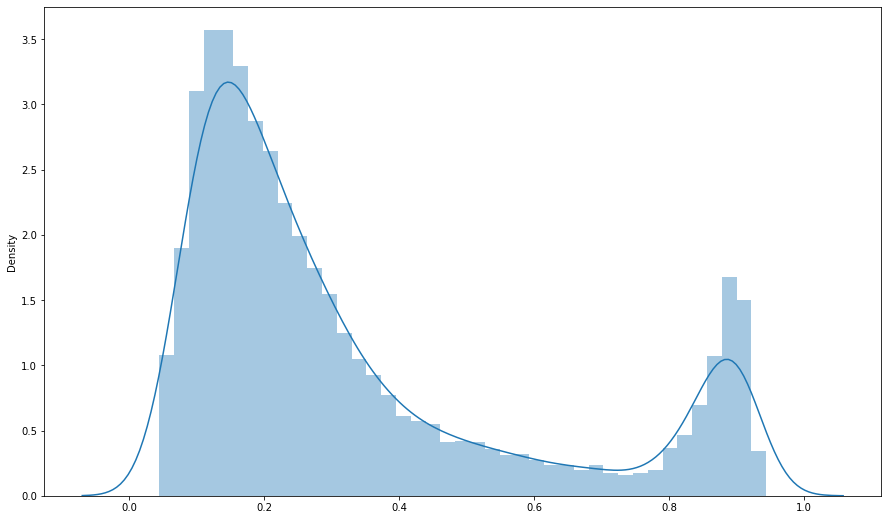

In [62]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

In [48]:
sample_sub = pd.read_csv(data_path+'/sample_submission.csv')
sample_sub = sample_sub.drop('problem', axis=1)

In [49]:
pred_y = pd.DataFrame({'user_id':test_data['user_id'], 'problem':pred_ensemble[:,0]})

In [50]:
sample_sub = pd.merge(sample_sub, pred_y, on='user_id', how='left')
sample_sub['problem'] = sample_sub['problem'].fillna(0)

In [66]:
sample_sub.to_csv("result_new8.csv", index = False)